<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Generative adversarial networks</b></h3>



В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
# !unzip archive.zip

In [5]:
DATA_DIR = './cats/'

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

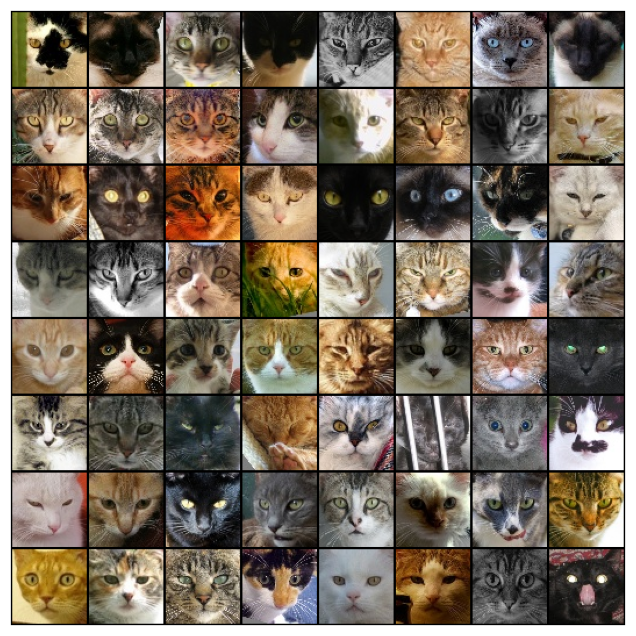

In [15]:
show_batch(train_dl,64)

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
!nvidia-smi

Thu Dec 14 11:53:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8              16W / 170W |    355MiB / 12288MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
discriminator = to_device(discriminator, device)

In [22]:
latent_size = 128

In [23]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # приводит интенсивность цветов по каналам в нормальное состояние.[-1,1]
                # Если надо будет потом привести к диапазону 0-1 то накинем сигму
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


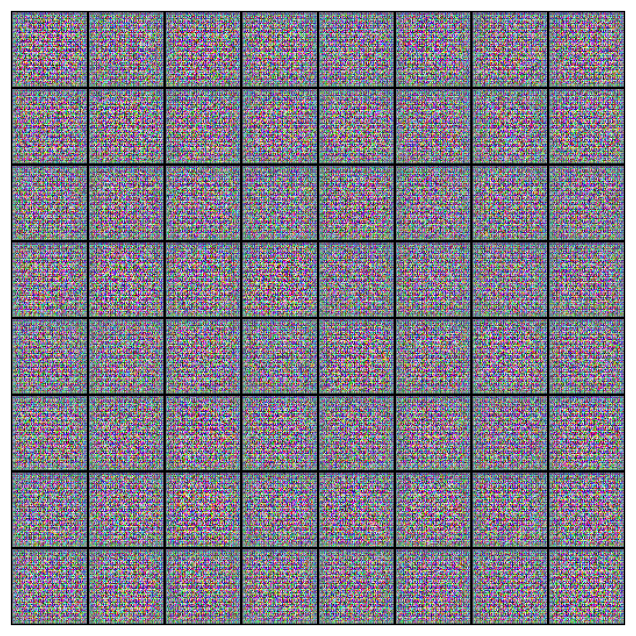

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [25]:
generator = to_device(generator, device)

In [40]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [28]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса
  * обновляем веса ДИСКРИМИНАТОРА

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 1
  * предсказываем дискриминаторором, реальное это изображение или нет
  * считаем лосс и обновляем веса ГЕНЕРАТОРА


В качестве функции потерь берем бинарную кросс-энтропию

In [32]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [33]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [34]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 8.0678, loss_d: 0.3875, real_score: 0.8815, fake_score: 0.1241


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 4.3234, loss_d: 0.5496, real_score: 0.8077, fake_score: 0.1819


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 3.7754, loss_d: 0.6946, real_score: 0.7806, fake_score: 0.2200


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 3.6929, loss_d: 0.7441, real_score: 0.7541, fake_score: 0.2478


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 4.3981, loss_d: 0.7309, real_score: 0.7679, fake_score: 0.2298


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.6115, loss_d: 0.7416, real_score: 0.7732, fake_score: 0.2297


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.5286, loss_d: 0.7012, real_score: 0.7872, fake_score: 0.2094


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.7238, loss_d: 0.6948, real_score: 0.7907, fake_score: 0.2133


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.8321, loss_d: 0.6574, real_score: 0.8033, fake_score: 0.1943


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.5054, loss_d: 0.6325, real_score: 0.8077, fake_score: 0.1932


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.4137, loss_d: 0.5790, real_score: 0.8218, fake_score: 0.1727


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.4896, loss_d: 0.6145, real_score: 0.8130, fake_score: 0.1887


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.8982, loss_d: 0.5292, real_score: 0.8338, fake_score: 0.1684


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.8345, loss_d: 0.5080, real_score: 0.8385, fake_score: 0.1597


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.8568, loss_d: 0.5321, real_score: 0.8431, fake_score: 0.1605


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 5.0904, loss_d: 0.5299, real_score: 0.8437, fake_score: 0.1513


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 5.1330, loss_d: 0.4451, real_score: 0.8653, fake_score: 0.1408


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 5.1587, loss_d: 0.4464, real_score: 0.8716, fake_score: 0.1216


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 5.3645, loss_d: 0.4201, real_score: 0.8669, fake_score: 0.1313


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 6.0572, loss_d: 0.4423, real_score: 0.8779, fake_score: 0.1243


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 5.7507, loss_d: 0.3948, real_score: 0.8874, fake_score: 0.1085


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 5.1404, loss_d: 0.4034, real_score: 0.8780, fake_score: 0.1287


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 6.2397, loss_d: 0.2877, real_score: 0.9106, fake_score: 0.0905


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 6.3091, loss_d: 0.4127, real_score: 0.8900, fake_score: 0.1085


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 6.4733, loss_d: 0.2584, real_score: 0.9179, fake_score: 0.0816


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 6.8586, loss_d: 0.2416, real_score: 0.9289, fake_score: 0.0743


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 6.7123, loss_d: 0.2757, real_score: 0.9171, fake_score: 0.0784


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 6.6956, loss_d: 0.2846, real_score: 0.9165, fake_score: 0.0862


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 6.6010, loss_d: 0.2765, real_score: 0.9253, fake_score: 0.0774


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 6.5287, loss_d: 0.2467, real_score: 0.9319, fake_score: 0.0677


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 6.0348, loss_d: 0.3405, real_score: 0.9064, fake_score: 0.0925


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 6.7598, loss_d: 0.2013, real_score: 0.9380, fake_score: 0.0623


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.4747, loss_d: 0.2982, real_score: 0.9216, fake_score: 0.0793


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 6.7259, loss_d: 0.2599, real_score: 0.9333, fake_score: 0.0689


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 7.0399, loss_d: 0.1705, real_score: 0.9373, fake_score: 0.0571


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 6.5142, loss_d: 0.2870, real_score: 0.9213, fake_score: 0.0804


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 7.2968, loss_d: 0.2369, real_score: 0.9326, fake_score: 0.0744


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 6.5832, loss_d: 0.2735, real_score: 0.9245, fake_score: 0.0706


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 7.0006, loss_d: 0.2326, real_score: 0.9375, fake_score: 0.0615


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.4603, loss_d: 0.2482, real_score: 0.9222, fake_score: 0.0804
Saving generated-images-0040.png


Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [35]:
losses_g, losses_d, real_scores, fake_scores = history

In [36]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

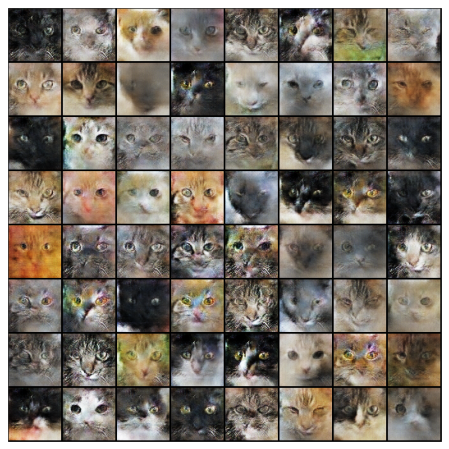

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

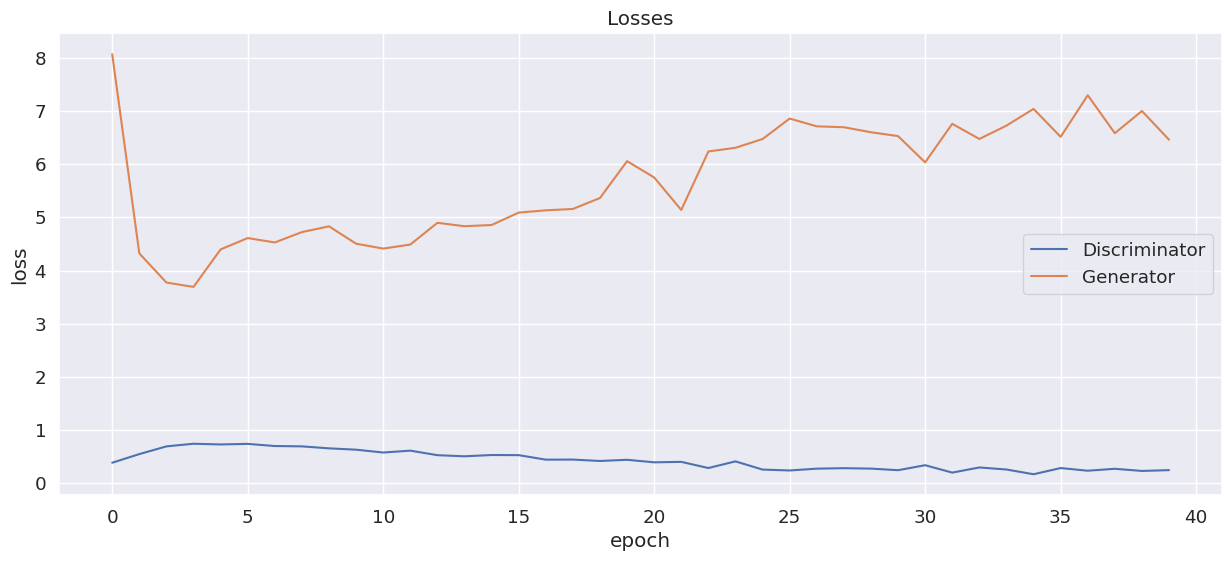

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

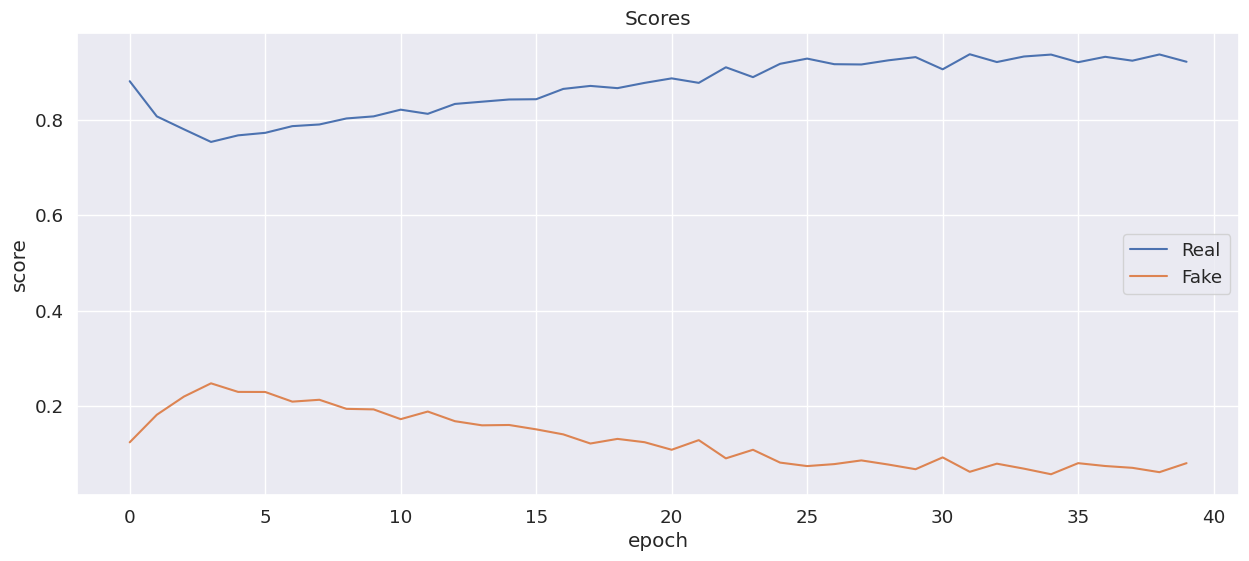

In [38]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Поведение графиков примерно такое же, как было показано на лекции